In [1]:
import os
from zipfile import ZipFile
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Необходимо разархивировать датасет в нужную директорию

In [ ]:
data_path_zip = "/content/drive/MyDrive/PyTorch_5/nturgbd_skeletons_s001_to_s017.zip"
extract_dir = "/content/drive/MyDrive/PyTorch_5/SK"
with ZipFile(data_path_zip) as zf:
    zf.extractall(extract_dir)

Соответствующие пути для содержимого архива и файла txt

In [ ]:
data_path = "/content/drive/MyDrive/PyTorch_5/SK/skeletons/"
#### список отсутсвующих элементов так же будет доступен 
broken_files_path = "/content/drive/MyDrive/PyTorch_5/missing_skeletons.txt"

In [ ]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [ 44, 14, 34, 40, 10, 50, 5, 24] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

Функция, которая позволяет нам считать данные для каждого класса

In [ ]:
def read_data(data_path, broken_files_path):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    raw_files = os.listdir(data_path)
    num_frames = 0

    for filename in raw_files:
        if filename not in broken_files:
            action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
            subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
            camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
            if action_class in training_classes and camera_id in training_cameras:  #and subject_id in training_subjects:
                if action_class in action_classes:
                    if files_counter[action_class] < 120:
                        files.append([filename,action_classes[action_class]])
                        files_counter[action_class] = files_counter[action_class] + 1
                else:
                    action_classes.update({action_class : counter})
                    files_counter.update({action_class : 1})
                    counter+=1
                    files.append([filename,action_classes[action_class]])
#                     labels.append([action_class])
    print("action classes: ", action_classes)
    print("action files: ", files_counter)
    
    return files, action_classes

In [ ]:
def get_nonzero_std(s): 
    index = s.sum(-1).sum(-1) != 0  
    s = s[index]
    if len(s) != 0:
        s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
    else:
        s = 0
    return s

# Функция фильтр для того, что бы найти только координаты x,y,z(т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
def read_skeleton_filter(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []
        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton_filter(file)
    data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

                else:
                    pass

    return data

В этой функции меняем количество фреймов подаваемых на вход модели
В задании нужно пронаблюдать зависимость качества обучения модели от количества кадров, которые мы подаем в модель. Т.е. то, cколько кадров у нас отведено на один блок. В ноутбуке мы обучали модель на 45 кадрах. Вам предлагается посмотреть в меньшую или большую сторону.



In [ ]:
def create_coords_blocks(test_file, chonk_len = 40):   
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(data_path + test_file[0])[0]
    label = test_file[1]
    slice_len = chonk_len * int(len(test_frames)/chonk_len)


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == chonk_len:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
            
    return blocks, new_labels

In [ ]:
##### список файлов с лейблами на каждый файл 
working_files_with_labels, action_classes = read_data(data_path, broken_files_path)

action classes:  {5: 0, 44: 1, 14: 2, 40: 3, 34: 4, 50: 5, 24: 6, 10: 7}
action files:  {5: 120, 44: 120, 14: 120, 40: 120, 34: 120, 50: 120, 24: 120, 10: 120}


In [ ]:
LABELS = {v: k for k, v in action_classes.items()}
print(LABELS)

{0: 5, 1: 44, 2: 14, 3: 40, 4: 34, 5: 50, 6: 24, 7: 10}


In [ ]:
len(working_files_with_labels)

960

In [ ]:
print(working_files_with_labels)

[['S010C001P013R002A005.skeleton', 0], ['S002C003P014R002A005.skeleton', 0], ['S002C003P014R001A044.skeleton', 1], ['S012C003P016R001A014.skeleton', 2], ['S005C003P010R002A040.skeleton', 3], ['S011C002P027R001A034.skeleton', 4], ['S011C001P017R002A050.skeleton', 5], ['S008C003P015R001A024.skeleton', 6], ['S004C003P003R002A040.skeleton', 3], ['S012C002P018R002A034.skeleton', 4], ['S013C003P016R001A050.skeleton', 5], ['S002C002P008R002A034.skeleton', 4], ['S007C002P028R001A010.skeleton', 7], ['S010C002P019R002A034.skeleton', 4], ['S008C001P033R001A034.skeleton', 4], ['S013C003P028R002A005.skeleton', 0], ['S008C003P015R002A024.skeleton', 6], ['S010C002P017R002A044.skeleton', 1], ['S016C001P039R002A040.skeleton', 3], ['S012C003P007R001A044.skeleton', 1], ['S010C001P008R001A040.skeleton', 3], ['S002C003P013R002A034.skeleton', 4], ['S011C002P018R002A014.skeleton', 2], ['S017C002P009R002A010.skeleton', 7], ['S016C001P025R001A005.skeleton', 0], ['S007C002P019R001A040.skeleton', 3], ['S011C003P

In [ ]:
data = []
labels = []
##########################################################################
numbers = {x: 0 for x in range(len(action_classes))} #####
##################################################################
for file in working_files_with_labels:
    frames_blocks, label = create_coords_blocks(file)
    if label != [] and numbers[label[0]] <= 150:
        numbers[label[0]] = numbers[label[0]] + len(label)
        data = data + frames_blocks
        labels = labels + label
data_np = np.asarray(data)
labels_np = np.asarray(labels)

data_sq = data_np.reshape(len(data_np), -1)
test_data = pd.DataFrame(data_sq)
test_labels = pd.DataFrame(labels_np)
test_data['labels'] = test_labels

Итоговый файл для загрузки

In [5]:
test_data.to_csv("skeletons_classes_40.csv", index = False)

NameError: ignored

In [ ]:
from torchvision import transforms

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch import optim
import time
import math

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [8]:
skeletons = pd.read_csv("skeletons_classes_40.csv")

In [9]:
LABELS = {0: "drop", 1: "headache", 2:  "wear jacket", 3: "cross hands in front", 4: "rub two hands together", 5: " punching/slapping other person", 6: "kicking something", 7:  "clapping"}

In [10]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,labels
0,0.343582,-0.131636,2.796781,0.334321,0.174186,2.719870,0.324273,0.471297,2.631597,0.403485,0.582353,2.581206,0.194410,0.349991,2.582528,0.097598,0.128170,2.628767,0.138166,-0.116630,2.614945,0.152282,-0.176070,2.599253,0.473957,0.334958,2.771091,0.493046,0.136862,2.829660,0.586698,-0.022283,2.682385,0.614079,-0.064489,2.643760,0.278066,-0.128742,2.725596,0.201409,...,0.259767,-0.130020,2.705268,0.199142,-0.499409,2.802932,0.168425,-0.820084,2.962896,0.199087,-0.901368,2.943798,0.390218,-0.126270,2.761366,0.381681,-0.451477,2.917189,0.339014,-0.783312,3.072563,0.385941,-0.846942,2.964602,0.303178,0.386336,2.609702,0.246184,-0.210451,2.487599,0.229516,-0.129148,2.583333,0.698213,0.007372,2.527886,0.683953,0.006100,2.580875,0
1,-0.102617,-0.142306,2.201375,-0.122486,0.144950,2.135401,-0.141183,0.422855,2.057418,-0.054072,0.523076,2.073909,-0.193924,0.268663,1.950517,-0.211488,0.034527,1.929083,-0.088376,-0.106852,1.999993,-0.060242,-0.141006,2.058226,-0.054398,0.303770,2.273683,0.017027,0.042619,2.324230,0.075560,-0.151231,2.290660,0.107049,-0.135908,2.295999,-0.127392,-0.135031,2.118398,-0.161075,...,-0.116683,-0.142592,2.112677,-0.148937,-0.515755,2.160999,-0.203693,-0.888173,2.277370,-0.104610,-0.932973,2.219657,-0.058038,-0.141779,2.201879,-0.237580,-0.361086,2.180278,-0.231289,-0.774694,2.255736,-0.131773,-0.820741,2.197608,-0.120203,0.348347,2.071664,0.063554,-0.325607,1.974269,0.054268,-0.268825,1.922572,0.069816,-0.294426,2.477629,0.027643,-0.243335,2.477833,0
2,-0.088271,-0.147568,2.192715,-0.106078,0.138111,2.127849,-0.121850,0.415797,2.049715,-0.053854,0.522715,2.051112,-0.179980,0.262746,1.941618,-0.129386,0.020111,1.934700,-0.055022,-0.201054,1.965532,-0.036176,-0.286057,1.979511,-0.035133,0.296705,2.265937,0.031458,0.049341,2.359862,0.058517,-0.202985,2.450392,0.026725,-0.264119,2.482856,-0.115511,-0.143368,2.114853,-0.149136,...,-0.115897,-0.136193,2.109240,-0.159892,-0.510728,2.154286,-0.208491,-0.886842,2.275908,-0.109222,-0.931374,2.217810,-0.057873,-0.137182,2.200990,-0.036379,-0.434433,2.387890,-0.159614,-0.834227,2.313243,-0.153722,-0.859263,2.410486,-0.127106,0.349949,2.066279,-0.164988,-0.371524,1.973904,-0.215969,-0.320413,1.961222,0.006555,-0.307269,2.434463,0.012870,-0.296789,2.428519,0
3,-0.050251,-0.103218,2.638716,-0.069884,0.196730,2.574562,-0.087466,0.488418,2.498312,-0.052239,0.617474,2.452217,-0.248253,0.389349,2.471294,-0.306652,0.141858,2.511820,-0.285697,-0.097210,2.524548,-0.269958,-0.175340,2.532195,0.097148,0.388248,2.575667,0.132188,0.135532,2.649247,0.151013,-0.089246,2.645400,0.149966,-0.177255,2.642852,-0.112302,-0.105480,2.587975,-0.177579,...,-0.120644,-0.095754,2.583062,-0.176744,-0.397757,2.654863,-0.187009,-0.744069,2.846515,-0.160593,-0.806058,2.723284,0.009889,-0.089749,2.621962,0.050958,-0.388495,2.719148,0.051124,-0.744828,2.904714,0.074722,-0.806959,2.781379,-0.082156,0.415951,2.530478,-0.283648,-0.248828,2.558489,-0.316026,-0.181982,2.523260,0.003598,0.656513,2.309928,0.073755,0.647060,2.312551,1
4,-0.055911,-0.094079,2.638422,-0.071055,0.199581,2.580839,-0.085907,0.486054,2.510983,-0.029283,0.599358,2.458295,-0.233368,0.389651,2.481933,-0.314708,0.156645,2.518797,-0.298229,-0.092314,2.540058,-0.283203,-0.170843,2.549689,0.096694,0.408479,2.555675,0.234012,0.364671,2.403397,0.116999,0.525040,2.352571,0.053266,0.591164,2.340751,-0.120590,-0.095632,2.583025,-0.176690,...,-0.119728,-0.086195,2.588386,-0.176868,-0.393978,2.658449,-0.187228,-0.744870,2.847769,-0.160616,-0.806811,2.724644,0.010395,-0.079436,2.628625,0.049385,-0.388958,2.725125,0.050323,-0.744374,2.906332,0.074127,-0.806471,2.783099,-0.086381,0.417857,2.535828,-0.268069,-0.245922,2.557883,-0.308415,-0.19

In [11]:
skeletons.shape

(1100, 3001)

## **Dataloader**

In [12]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(40,25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        

        return (item, label) 

In [13]:
dataset = Skeleton_Dataset(file_path = "skeletons_classes_40.csv", transform=None)

In [14]:
skel, lab = dataset.__getitem__(10)
skel, lab = dataset[10]

In [15]:
LABELS[lab]

'cross hands in front'

In [16]:
skel.shape

(40, 75)

In [17]:
skels_for_draw = skel.reshape(-1,25,3)

## **Оборачиваем в Даталоадер:**

In [20]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

### Инициализируем наши переменные и модель

In [21]:
class LSTM_net(nn.Module):
    # Для того, что бы инициализировать LSTM нам нужно указать:
    # input_dim - размерность входного тензора. тензор входит в формате (seq_len, batch, input_dim)
    # (batch_size, seq, inp_dim) - if batch_first=True
    # hidden_dim - размерность вектора состояния h
    # output_dim - размерность выхода
    # layer_num - количество скрытых слоев в сети
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [22]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=3, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [23]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# **40** **кадров**

In [28]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.2602  / cross hands in front ✗ (clapping)
epoch : 19 iter : 6 (1m 21s) 1.2509  / clapping ✗ (headache)
epoch : 38 iter : 12 (2m 42s) 1.7363  / cross hands in front ✗ (headache)
epoch : 57 iter : 18 (4m 3s) 1.3171  / clapping ✓
epoch : 76 iter : 24 (5m 25s) 1.2716  / clapping ✗ (headache)
epoch : 96 iter : 4 (6m 46s) 0.8012  /  punching/slapping other person ✓
epoch : 115 iter : 10 (8m 7s) 1.0899  / rub two hands together ✓
epoch : 134 iter : 16 (9m 28s) 0.9100  / clapping ✓
epoch : 153 iter : 22 (10m 49s) 1.0101  / wear jacket ✗ (drop)
epoch : 173 iter : 2 (12m 11s) 0.8895  / clapping ✓
epoch : 192 iter : 8 (13m 32s) 0.9092  / kicking something ✓
epoch : 211 iter : 14 (14m 54s) 1.0305  / cross hands in front ✓
epoch : 230 iter : 20 (16m 15s) 0.5973  /  punching/slapping other person ✓
epoch : 250 iter : 0 (17m 35s) 0.6068  / headache ✓
epoch : 269 iter : 6 (18m 56s) 0.6017  / rub two hands together ✗ (wear jacket)
epoch : 288 iter : 12 (20m 18s) 0.9613  / h

При кол-ве lstm модулей 2, кадров 50 Accuracy of the network: 50.0

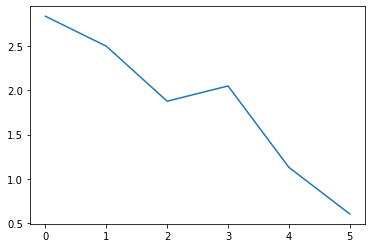

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()


In [ ]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   50.0


При кол-ве lstm модулей 4, кадров 40 Accuracy of the network: 

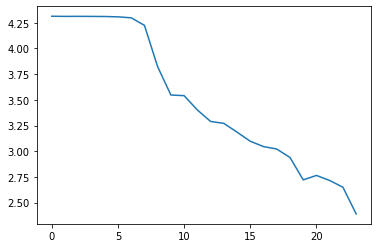

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)

In [ ]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   43.27272727272727


При кол-ве lstm модулей 3, кадров 40, batch_size = 32, epoch 300: Accuracy of the network:  35.63636363636363

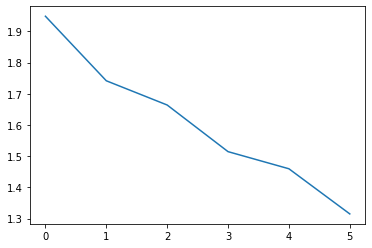

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)

In [27]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   35.63636363636363


При кол-ве lstm модулей 3, кадров 40, batch_size = 32, epoch 600: Accuracy of the network: 56.72727272727273

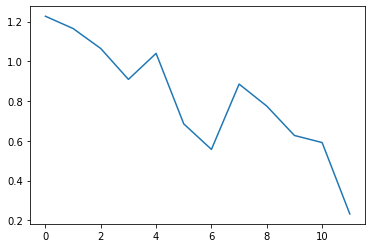

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)

In [30]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   56.72727272727273
